In [1]:
#Import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import sys
from pathlib import Path
#!conda install --yes --prefix {sys.prefix} boto
import boto
import shutil
#!conda install --yes --prefix {sys.prefix} tqdm
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import numpy as np
import skbio
#import fastcluster #this package makes skbio run faster clustermaps but can be tricky with missing values from pairwise comparisons
from functools import reduce
#!conda install --yes --prefix {sys.prefix} biopython
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from biom import load_table
from biom.table import Table
from collections import defaultdict
from collections import Counter
import statistics
import itertools as it
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as mcolors
from qiime2 import Artifact
import tempfile
import zipfile
import yaml

#!conda install --yes --prefix {sys.prefix} -c etetoolkit ete3 
#!conda install -c bioconda seqkit
#pip install ete3
#conda install -c anaconda pyqt
#from ete3 import Tree, TreeStyle
%matplotlib inline

#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

In [2]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(community):
    if community == "16S":
        comm_id, comm = '16S', '02-PROKs'
        table_list = glob.glob('{0}/*/03-DADA2d/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all 16S tables")
    if community == "18S":
        comm_id, comm = '18S','02-EUKs'
        table_list = glob.glob('{0}/*/08-DADA2/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all tables")

    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm, comm_id

In [3]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency', 'table_id', 'forward_trim', 'reverse_trim']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv('MANIFEST.tsv', sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    #merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates() 
    print('Set up manifest ...')
    
    metadata = pd.read_csv('METADATA.tsv', sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    merged = merged.replace({'V2': '16S'}, regex=True)
    merged = merged[merged.feature_frequency != 0]
    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [4]:
def rename_move_all_taxonomies(comm):
    dr = comm+'/intermediate_files/all_trims'
    if not os.path.isdir(dr):
        for root, dirs, files in os.walk(dr): #rename all taxonomy.tsv by their trimlengths
            for file in files:
                if file == "taxonomy.tsv":
                    spl = root.split("/"); newname = spl[-6]; sup = ("/").join(spl[:-6])
                    shutil.copy(root+"/"+file, sup+"/"+newname+".tsv");# shutil.rmtree(root)
        files = glob.glob('{0}F*R*.tsv'.format(dr))
        os.mkdir(dr)
        for file in files:
            shutil.move(file, dr) #puts all tsvs in new directory with correct names
    print('Renamed all taxonomies.')

In [5]:
def rename_move_statistics(comm):
    dr = comm+'/intermediate_files/'
    statdir = comm+'/intermediate_files/all_statistics'
    if not os.path.isdir(statdir): #check if the folder exists
        for root, dirs, files in os.walk(dr): #rename all stats.tsv by their trimlengths
            for file in files:
                if file == "stats.tsv":
                    spl = root.split("/"); newname = spl[-5]; sup = ("/").join(spl[:-6])
                    shutil.copy(root+"/"+file, sup+"/"+newname+".tsv");# shutil.rmtree(root)
        files = glob.glob('{0}F*R*.tsv'.format(dr))
        os.mkdir(statdir)
        for file in files:
            shutil.move(file, statdir) #puts all tsvs in new directory with correct names
    print('Renamed all statistics.')

In [6]:
def pick_metadata(comm, comm_id, composition, runnumber, R='all', F='all'):
#make df of features/composition+run+comm

    composition = composition
    runnumber = runnumber
    R = R
    F = F

    files = glob.glob('{0}*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        #tax['table_id'] = str(filename.split('/')[-1])
        #tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        #tax['forward_trim'], tax['reverse_trim'] = tax['table_id'].str.split('R', 1).str
        #tax['forward_trim'] = tax['forward_trim'].map(lambda x: x.lstrip('F'))
        #tax["forward_trim"] = pd.to_numeric(tax["forward_trim"])
        #tax["reverse_trim"] = pd.to_numeric(tax["reverse_trim"])
        taxos.append(tax)
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()
    #taxos.to_csv(comm+'/taxos.tsv', sep = '\t')
    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    separated = separated[separated["community"] == comm_id]
    separated = separated[separated["composition"] == composition]
    separated['run-number']= separated['run-number'].astype(str)
    separated = separated[separated["run-number"] == runnumber]
    separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    separated['ratio'] = separated['feature_frequency']/(separated['total'])
    separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return composition, runnumber, R, F, separated, files

In [7]:
def pick_taxonomies(comm, comm_id,  composition, runnumber, files):
#generate folder of split taxonomies by runnumber and composition
    # Directory
    directory = composition+runnumber
    # Parent Directory path
    parent_dir = comm+'/intermediate_files/all_taxonomies'
    # Path
    path = os.path.join(parent_dir, directory)
    # Create the directory
    # 'GeeksForGeeks' in
    # '/home / User / Documents'
    if not os.path.isdir(parent_dir+'/'+directory): 
        os.mkdir(path)
        for filename in files:
            d = 'all_taxonomies/'
            separated_copy = separated[separated['table_id'] == (filename.split(d)[1]).split('.tsv')[0]] #only select the rows from the right table_id
            taxonomy = pd.read_csv(filename, sep='\t')
            taxonomy = taxonomy.rename(columns={"Feature ID": "feature_id"}, errors="raise")
            newz = taxonomy.merge(separated_copy, how='left', on=['feature_id', 'Taxon', 'Confidence'])
            new = newz.drop_duplicates()
            new = new.fillna(0)
            new = new[new.feature_frequency != 0]
            new = new.rename(columns={"feature_id":"Feature ID"}, errors="raise")
            new = new[['Feature ID', 'Taxon', 'Confidence']].copy()
            new = new.drop_duplicates()
            new = new.set_index('Feature ID')
            if new.empty:
                print('DataFrame from '+ filename +' is empty!')
            else:
                new.to_csv(filename.split(d)[0]+d+composition+runnumber+'/'+runnumber+filename.split(d)[1], sep = '\t')
           
            print('Split taxonomies')
    else:
        print("Taxonomies already split")

In [8]:
def parse_quality_scores(runnumber, comm_id, composition):
    directions = ['forward', 'reverse']
    for direction in directions:
        #read the csv with read summary scores from qiime2
        q_scores = pd.read_csv("/Users/Diana/data/mocks-to-share-with-Diana/R{0}_{1}_{2}_Avg/{3}-seven-number-summaries.tsv".format(runnumber, comm_id,composition,direction), sep="\t")
        q_scores = q_scores.set_index(['Unnamed: 0'])
        q_scores = q_scores.transpose()
        q_scores = q_scores.add_suffix('_'+direction) #df will be split direction-wise
        q_scores[direction+'_trim'] = q_scores.index #rows become nt position
        #make columns as numerical value for calculation of averages
        q_scores[direction+'_trim'] = q_scores[direction+'_trim'].astype('int64')
        separated[direction+'_trim'] = separated[direction+'_trim'].astype('int64')
        q_scores = q_scores.set_index([direction+'_trim'])
        #calculates the average read quality (i.e. average of median wuality at each nt position from the trimming position)
        q_scores[direction+'_avg'] = np.nan
        for trimlength in range(len(q_scores.index)):     
            q_scores.at[trimlength, direction+'_avg'] = q_scores[['50%_'+direction]].iloc[[0,trimlength]].mean(axis=0) #axis=0 will compute the mean column-wise
        if direction == 'forward':
            f_q_scores = q_scores.copy()
            sepqscores = separated.merge(q_scores, on = 'forward_trim', how = 'left')
        else:
            r_q_scores = q_scores.copy()
            sepqscores = sepqscores.merge(q_scores, on = 'reverse_trim', how = 'left')
        
    f_q_scores['length'] = f_q_scores.index
    r_q_scores['length'] = r_q_scores.index
    
    mergedscores = f_q_scores.merge(r_q_scores, on='length')
    toplot = pd.melt(mergedscores, id_vars ='length', value_vars =['50%_forward', '50%_reverse'], var_name='Read direction')
    
    ax = sns.lineplot(data=toplot, x="length", y="value", style="Read direction", ci=None)
    plt.xlabel("Read length")
    plt.ylabel("Median quality score at nucleotide position")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_readsqual_50perc_length.png',
            bbox_inches = "tight")
        
    return sepqscores, mergedscores, f_q_scores, r_q_scores

In [9]:
def make_fasta(comm, R, F, composition, runnumber):
    
    fastaoutfilename = comm+'/intermediate_files/all_seqs/allfasta.fasta'
    
    if not os.path.isfile(fastaoutfilename):
        os.mkdir(comm+'/intermediate_files/all_seqs')
        # Get list of all .qza
        repseqs = glob.glob('{0}/*/*/representative_sequences.qza'.format(comm+'/intermediate_files/all_trims'), recursive=True)
        #for i in tqdm
        for repseq in repseqs:
            with zipfile.ZipFile(repseq, 'r') as zipObj:
                # Get a list of all archived file names from the zip
                listOfFileNames = zipObj.namelist()
                # Iterate over the file names
                for fileName in listOfFileNames:
                    # Check filename endswith fasta
                    if fileName.endswith('.fasta'):
                        # Extract a single file from zip
                        zipObj.extract(fileName, 'temp_fasta')
                        
    
        with open(fastaoutfilename, 'wb') as outfile:
            for filename in glob.glob('temp_fasta/*/*/*.fasta'):
                if filename == fastaoutfilename:
                    # don't want to copy the output into the output
                    continue
                with open(filename, 'rb') as readfile:
                    shutil.copyfileobj(readfile, outfile)
        shutil.rmtree('temp_fasta', ignore_errors=False, onerror=None)
    

    if R!='all':
        rallfs = separated[separated.Reverse_trim == R]
        separated_dic = pd.Series(rallfs.Taxon.values,rallfs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()
    if F!='all':
        fallrs = separated[separated.Forward_trim == F]
        separated_dic = pd.Series(fallrs.Taxon.values,fallrs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()

    fa = SeqIO.parse(comm+'/intermediate_files/all_seqs/allfasta.fasta',
                 "fasta")
    seqs_i_want = [] #we'll put the good sequences here
    for record in fa: #a SeqRecord has the accession as record.id, usually.
        if record.id in separated_dic.keys(): #This is how you check if the accession is in the values of the dict
            seqs_i_want.append(record)
    #Now we can write the list of records to a fasta file. This will take care of the formatting etc
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta', "w") as f:
        SeqIO.write(seqs_i_want, f, "fasta")
        
    
    
    return print('Saved selected sequences as '+comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta')

In [10]:
def load_df(comm, separated):
    files = glob.glob('{0}*.tsv'.format(comm+'/intermediate_files/all_statistics/'))
    stats = []
    for filename in files:
        df = pd.read_csv(filename, sep='\t')
        df = df.drop(0)
        df['table_id'] = str(filename.split('/')[-1]) #add a table_id column
        df["table_id"] = df["table_id"].str.replace(".tsv", "")
        stats.append(df)
    print('Appended all taxonomies to stats')

    stats = pd.concat(stats)
    stats = stats.rename(columns={"sample-id": "file"}, errors="raise")
    stats = stats.replace({'V2': '16S'}, regex=True)
    target_stats = separated.merge(stats, how='left', on=['file', 'table_id'])
    target_stats[["percentage of input non-chimeric"]] = target_stats[["percentage of input non-chimeric"]].apply(pd.to_numeric)
    target_stats['forward_trim'] = target_stats['forward_trim'].replace(0,300)
    target_stats['reverse_trim'] = target_stats['reverse_trim'].replace(0,300)
    target_stats = target_stats[target_stats.feature_frequency != 0]
    target_stats['proportion of input non-chimeric'] = target_stats['percentage of input non-chimeric']/100
    target_stats['bool_max_retained'] = target_stats['proportion of input non-chimeric'].ge(0.6) #to get a bool table for comparative table quickly see regions of high % of kept reads
    target_stats['bool_max_retained'] = target_stats['bool_max_retained'].replace({True: 1, False: 0})
    forhm = pd.pivot_table(target_stats, values= 'proportion of input non-chimeric', index='forward_trim', columns='reverse_trim')
    #forhm.replace(0, np.nan, inplace=True)
    forhm.rename({300: 'No trim'}, axis=0, inplace=True)
    forhm.rename({300: 'No trim'}, axis=1, inplace=True)
    
    bool_hm = pd.pivot_table(target_stats, values='bool_max_retained', index='forward_trim', columns='reverse_trim')
    bool_hm.rename({300: 'No trim'}, axis=0, inplace=True)
    bool_hm.rename({300: 'No trim'}, axis=1, inplace=True)
    
    # Create a custom colormap that goes from black to grey
    colors = ['black', '#BEBEBE']  # colors can also be represented in RGB format
    cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', colors)
    ax = sns.heatmap(bool_hm, cmap=cmap)#, annot=True, annot_kws={"fontsize":3})#, cbar=False)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.set_xlabel('Reverse read length (nt)', fontsize=15)
    ax.set_ylabel('Forward read length (nt)', fontsize=15)

    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_maxbool_hm.png',
                bbox_inches = "tight", dpi=300)
    plt.clf()
    
    #forhm = forhm.fillna(0)
    ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True), vmin=0, vmax=1)#, annot=True, annot_kws={"fontsize":3})#, cbar=False)
    #ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.set_xlabel('Reverse read length (nt)', fontsize=15)
    ax.set_ylabel('Forward read length (nt)', fontsize=15)
    
    #plt.figure(figsize=(12,12))
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_readsretained_hm.png',
                bbox_inches = "tight", dpi=300)
    plt.clf()
    
    #for the line plot version
    toplot = pd.melt(target_stats, id_vars ='percentage of input non-chimeric', value_vars =['forward_trim', 'reverse_trim'], var_name='Read direction')
    ax = sns.lineplot(data=toplot, x="value", y="percentage of input non-chimeric", style="Read direction", ci=None)
    plt.xlabel("Read length (nt)")
    plt.ylabel("% of reads retained")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_readsretained_line.png',
                bbox_inches = "tight")
    
    return target_stats, forhm

In [11]:
## to import the expected taxonomies and transofrm to ratios
def expected_df(comm, composition, separated):
    expected_silva = pd.read_csv('in-silico-mocks/'+comm+'/expected.tsv', sep='\t')
    expected_silva_selected = expected_silva.loc[~((expected_silva[composition+'_percent_expected'] == 0))]
    expected_silva_selected[composition+'_ratio_expected'] = expected_silva_selected[composition+'_percent_expected']/(expected_silva_selected[composition+'_percent_expected'].sum())
    ax = sns.barplot(x=composition+"_ratio_expected", y="Clone_name", data=expected_silva_selected, saturation=.5)
    ax.set(xlabel='Relative abundance', ylabel='Group')
    #ax.bar_label(ax.containers[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.figure.savefig(comm+composition+'_expected.png', bbox_inches='tight')
    fig = ax.get_figure()
    fig.savefig('outputs/'+comm+composition+'_expected.png', bbox_inches = "tight")
    
    plt.clf()
        
    #make r2 fig
    
    expobs_comp = []
    fpfps = []
    
    for value in separated['table_id'].unique():
        for replicate in separated['sample-id'].unique():
            df = separated[separated['table_id'] == value]
            df = df[df['sample-id'] == replicate]
            df = df.merge(expected_silva_selected, on='Taxon', how='outer')
            df = df.fillna(0)
            
            forfps = df.groupby(['forward_trim','reverse_trim', 'table_id', composition+'_ratio_expected','sample-id', 'Clone_name', 'Confidence']).sum()
            forfps = forfps.reset_index()
            forfps['table_id'] = value
            forfps['sample-id'] = replicate
            forfps['forward_trim'], forfps['reverse_trim'] = forfps['table_id'].str.split('R', 1).str
            forfps['forward_trim'] = forfps['forward_trim'].map(lambda x: x.lstrip('F'))
            forfps["forward_trim"] = pd.to_numeric(forfps["forward_trim"])
            forfps["reverse_trim"] = pd.to_numeric(forfps["reverse_trim"])
            forfps["Clone_name"].replace({0: "False positive"}, inplace=True)
            forfps[composition+'_ratio_expected'] = pd.to_numeric(forfps[composition+'_ratio_expected'])
            fpfps.append(forfps)
            
            
            grouped = df.groupby(['forward_trim','reverse_trim', 'table_id', composition+'_ratio_expected','sample-id', 'Clone_name']).sum()
            grouped = grouped.reset_index()
            grouped['table_id'] = value
            grouped['sample-id'] = replicate
            grouped['forward_trim'], grouped['reverse_trim'] = grouped['table_id'].str.split('R', 1).str
            grouped['forward_trim'] = grouped['forward_trim'].map(lambda x: x.lstrip('F'))
            grouped["forward_trim"] = pd.to_numeric(grouped["forward_trim"])
            grouped["reverse_trim"] = pd.to_numeric(grouped["reverse_trim"])
            grouped["Clone_name"].replace({0: "False positive"}, inplace=True)
            grouped[composition+'_ratio_expected'] = pd.to_numeric(grouped[composition+'_ratio_expected'])
            expobs_comp.append(grouped)
        

    expobs_comp = pd.concat(expobs_comp)
    fpfps = pd.concat(fpfps)
    grouped_by_trims = expobs_comp.groupby(['forward_trim', 'reverse_trim'])
    test = (grouped_by_trims.apply(lambda x: pd.Series(stats.linregress(x[composition+'_ratio_expected'], x['ratio'])))
        .rename(columns={
            0: 'slope',
            1: 'intercept',
            2: 'rvalue',
            3: 'pvalue',
            4: 'stderr'}))
  
    test['r2'] = test['rvalue']**2
    testcopy = test.reset_index()
    testcopy["forward_trim"].replace({0: 300}, inplace=True) #0 trim length translates to no trimming, so max read length
    testcopy["reverse_trim"].replace({0: 300}, inplace=True)
    tohm = testcopy.pivot("forward_trim", "reverse_trim", "r2")
    #tohm.fillna(0)
    tohm.rename({300: 'No trim'}, axis=0, inplace=True)
    tohm.rename({300: 'No trim'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm,cmap=("coolwarm"), vmin=0, vmax=1)#, annot=True, annot_kws={"fontsize":3})
    ax.invert_yaxis()

    ax.set_xlabel('Reverse read length (nt)', fontsize=15)
    ax.set_ylabel('Forward read length (nt)', fontsize=15)

    fig = ax.get_figure()
    #fig.figure(figsize = (16,16))
    fig.savefig('outputs/'+comm_id+composition+runnumber+'_r2.png', bbox_inches = "tight", dpi=300)
    # get max and min values
    print('The min value is {0} and the max value is {1}'.format(tohm.at[tohm.stack().index[np.argmin(tohm.values)]], 
                                                                 tohm.at[tohm.stack().index[np.argmax(tohm.values)]]))


    return expected_silva_selected, testcopy, expobs_comp, tohm, fpfps, df

In [12]:
def make_tbd_hm(comm, composition, runnumber, level=7):
    
    if not os.path.isdir('Bacaros_Beta'):
        ! git clone https://github.com/alexmanuele/Bacaros_Beta.git
        print("Bacaros Beta was cloned.")
    else:
        print("Bacaros Beta is already cloned.")
    
    #Move the expected community to the taxonomies folder for comparison
    dest_dir = comm+'/intermediate_files/all_taxonomies/'+composition+runnumber
    
    for file in glob.glob('in-silico-mocks/'+comm+'/'+composition+r'/*/data/taxonomy.tsv'):
        print(file+' was moved.')
        shutil.copy(file, os.path.join(dest_dir, 'expected.tsv'))
        
    tax_list = glob.glob('{0}/*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'+composition+runnumber))
    textfile = open("tax_comp.txt", "w")
    for element in tax_list:
        textfile.write(element + "\n")
    textfile.close()
    print("Saved all taxonomies list as tax_comp.txt")

    if not os.path.isdir(dest_dir+'/TBD1'):
        for i in range(1, 8):
            output_dir = 'TBD'+str(i)
            os.mkdir(output_dir)
            ! python Bacaros_Beta/run_beta.py --input tax_comp.txt --metric t --l $i --output $output_dir
            shutil.move(output_dir, dest_dir)
    else:
        print("BTD Already ran")
        
    bacaros_dm = pd.read_csv(dest_dir+'/TBD'+str(level)+'/tax_comp.csv')
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    #bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    #my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    #plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[['expected']].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == 'expected'], inplace=True)
    against_exp['forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['forward_trim'] = [s.split(runnumber+'F')[1] for s in against_exp['forward_trim']]
    against_exp['reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["forward_trim"] = pd.to_numeric(against_exp["forward_trim"])
    against_exp["reverse_trim"] = pd.to_numeric(against_exp["reverse_trim"])
    against_exp["forward_trim"].replace({0: 280}, inplace=True)
    against_exp["reverse_trim"].replace({0: 290}, inplace=True)
    tohm = against_exp.pivot("forward_trim", "reverse_trim", "expected")
    tohm.rename({280: 'No trim'}, axis=0, inplace=True)
    tohm.rename({290: 'No trim'}, axis=1, inplace=True)
    #tohm["10"] = np.nan
    #tohm.rename({280: 'Full'}, axis=0, inplace=True)
    #tohm.rename({290: 'Full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), vmin=0, vmax=1)#, annot=True, annot_kws={"fontsize":3})
    ax.invert_yaxis()
    #ax.set(xlabel='Reverse read length (nt)', ylabel='Forward read length (nt)')
    ax.set_xlabel('Reverse read length (nt)', fontsize=15)
    ax.set_ylabel('Forward read length (nt)', fontsize=15)
    

    #ax=plt.gca()
    #ax.set_xlim(0, 280)
    #ax.set_ylim(0, 290)

    #plt.figure(figsize=(15,15))
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{level}bacaros.png',
                bbox_inches = "tight", dpi=300)
    
    # get max and min values
    print('The min value is {0} and the max value is {1}'.format(tohm.at[tohm.stack().index[np.argmin(tohm.values)]], 
                                                                 tohm.at[tohm.stack().index[np.argmax(tohm.values)]]))

    return tohm, dest_dir, against_exp

In [13]:
#run 1 sample t test
#takes trimcombination in format F40R40
def ttst(trimcombination, expected_silva_selected):
    df_with_groups = expobs_comp[expobs_comp.table_id == trimcombination]
    
    #add if empty, return message saying this trim length is bad!
    
    means = df_with_groups.groupby('Clone_name').mean()
    newsi=means[[composition+'_ratio_expected', 'ratio']].copy()
    newsi.sort_values(composition+'_ratio_expected', ascending = False)
    newsi['Difference'] = newsi[composition+'_ratio_expected'] / newsi['ratio']
    newsi
    
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments
    df_with_groups = df_with_groups.sort_values(composition+'_ratio_expected', ascending = False)
    ax = sns.boxplot(x='ratio', y='Clone_name', data=df_with_groups)
    ax.set(
    xlabel='Relative abundance', 
    ylabel='Clone')
    plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(ax.lines, color='k')
    ax.figure.savefig(f'outputs/{comm_id}{composition}{runnumber}_ttest{trimcombination}.png',
                    bbox_inches = "tight")

    
    groups = df_with_groups['Clone_name'].unique()
    results = []
    for group in groups:    
        arr = df_with_groups[(df_with_groups['Clone_name'] == group)]['ratio'].values  #Filter the dataframe. 
        results.append({'Clone_name': group,
                        'ratios': arr}) #Make a single "record" containing the table id, replicate, and ratio array.
        r_gr = pd.DataFrame.from_records(results)
    
   
    new_row = {'Clone_name':'False positive', composition+'_ratio_expected':0}
    expected_silva_selected = expected_silva_selected.append(new_row, ignore_index=True)
    expected_silva_selected = expected_silva_selected.sort_values('Clone_name')
    r_gr = r_gr.sort_values('Clone_name')
    
    y = expected_silva_selected[composition+'_ratio_expected']
    for i in range(len(y[0:-1])):
        xi = r_gr.iloc[i]['ratios']
        yi = y[i]
        print(r_gr.iloc[i]['Clone_name'])
        print(stats.ttest_1samp(xi, yi))
        #but there are outliers
    return (r_gr, newsi)

In [14]:
def make_phylo_tree():
    tax_key = separated[['Taxon', 'feature_id']].copy() #extract taxon and f_id columns from the community + composition selected
    tax_key['key'] = [s.split('; ')[-2:] for s in tax_key['Taxon']] #extract only the last two tax ranks for tip labels on the tree
    tax_key['key'] = tax_key['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to one string
    tax_keys = tax_key.copy()
    tax_keys_dic = pd.Series(tax_keys.key.values,tax_keys.feature_id.values).to_dict() #make into dictionary for each asv entry the taxonomic name
    
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta') as original, open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'_taxoids.fasta', 'w') as corrected:
        for seq_record in SeqIO.parse(original, 'fasta'):
            if seq_record.id in tax_keys_dic:
                seq_record.id = seq_record.description = tax_keys_dic[seq_record.id]
            SeqIO.write(seq_record, corrected, 'fasta')
            
    ! seqkit rmdup -n < $comm'/intermediate_files/all_seqs/R'$R'F'$F$runnumber$composition'_taxoids.fasta' > out.fa
    
    ! wc -l out.fa
    
    # Read in the file
    with open('out.fa', 'r') as file :
        filedata = file.read()

    # Replace the target strings because misinterpreted by FastTree
    filedata = filedata.replace('(', '[')
    filedata = filedata.replace(')', ']')

    # Write the file out again
    with open('out.fa', 'w') as file:
        file.write(filedata)
    
    ! ~/mafft-mac/mafft.bat out.fa > aligneddedup.fasta
    
    ! ~/FastTree -gtr -nt < aligneddedup.fasta > tree_stg.nwk
    
    return tax_key

In [89]:
def thresholds():
    dic = {
        "Domain": f'{dest_dir}/TBD1/tax_comp.csv',
        "Phylum": f'{dest_dir}/TBD2/tax_comp.csv',
        "Class": f'{dest_dir}/TBD3/tax_comp.csv',
        "Order": f'{dest_dir}/TBD4/tax_comp.csv',
        "Family": f'{dest_dir}/TBD5/tax_comp.csv',
        "Genus": f'{dest_dir}/TBD6/tax_comp.csv',
        "Species": f'{dest_dir}/TBD7/tax_comp.csv'
    }
    thresholds = [1.0, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05, 0]
    df = pd.DataFrame(columns=['Rank', *thresholds]) #* unpack the list and adds to list, **is for unpacking dictionaries
    #eg. d3 = {**d1, **d2} or l3 = [*l1, *l2]
    for key in dic.keys():
        #tohm, dest_dir = make_tbd_hm(comm, composition, runnumber, level='6')
        #tohm, bacaros_dm, agexp = make_tbd_hm(dic[key], expected_file) #input the value of each key from the dictionary
        tohm = pd.read_csv(dic[key], index_col=0)
        row ={'Rank': key} #make an empty dictionary
        for thresh in thresholds:
            pp = ((tohm[tohm > thresh].count().sum())/tohm.size)*100
            row[thresh] = pp
        df = df.append(row, ignore_index=True)
    df_thresh =df.copy()
    df_thresh.to_csv(f'outputs/{comm_id}_{composition}_{runnumber}_adfile2.csv', index=False)
    
    newdf = df_thresh.set_index(['Rank'])
    newdf['Rank'] = newdf.index
    melted = newdf.melt('Rank', var_name='Thresholds', value_name='TSI')
    melted[["Thresholds", "TSI"]]=melted[["Thresholds", "TSI"]].apply(pd.to_numeric)
    
    sns.set_context('paper')
    fig = plt.figure(figsize=(5,5))
    p = sns.lineplot(data=melted, x="Thresholds", y="TSI", hue='Rank', legend = True)
    p.set(ylim=(0, 100))
    p.set(xlim=(0,1))
    p.set_xlabel("\u03B2 diversity") #, fontsize = 10)
    p.set_ylabel("Percentage of tables",)# fontsize = 10)
    #p.invert_xaxis()
    ax = p.get_figure()
    ax.savefig(f'outputs/thresholds{comm_id}_{composition}_{runnumber}_with_legend.png', format='png', dpi=600, bbox_inches="tight")
    plt.clf()
    
    sns.displot(melted, x="TSI", hue="Rank", multiple='stack', kind="kde", bw_adjust=.45)
    plt.savefig(f'outputs/{comm_id}_{composition}dist_kde.png', dpi=300)
    
    return df_thresh, melted

In [16]:
def make_fold_change_plots(expobs_comp, composition):
    #add the keys to expobs for matching with the tree tip labels
    expobs_comp['key'] = [s.split('; ')[-2:] for s in expobs_comp['Taxon']] #extract only the last two tax ranks for visualization
    expobs_comp['key'] = expobs_comp['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
    expobs_comp['ratio'] = expobs_comp['ratio'].fillna(0)
    
    separcopy = expobs_comp.copy()
    separcopy['Phylum'] = separcopy['Taxon'].str.split('; ').str[1]
    separcopy['Phylum'] = separcopy['Phylum'].str.split('p__').str[1]
    
    separcopy[[composition+'_ratio_expected']] = separcopy[[composition+'_ratio_expected']].apply(pd.to_numeric)
    separcopy['Type'] = np.where(
        separcopy[composition+'_ratio_expected'] > 0, 'TP', 'FP')
    
    separcopy['Size'] = separcopy['ratio'].copy()
    separcopy = separcopy.rename(columns={"key": "ID"})
    
    clonenames = separcopy.Clone_name.unique().tolist()
    clonenames_id = [clonename.replace(' ', '_') for clonename in clonenames]
    clonenames_id = [clonename.replace('(', '') for clonename in clonenames_id]
    clonenames_id = [clonename.replace(')', '') for clonename in clonenames_id]
    
    #if false positive, divide by small number
    for clonename in clonenames:
        clone = separcopy.loc[separcopy['Clone_name'] == clonename]
        clone = clone[['Forward_trim', 'Reverse_trim', composition+'_ratio_expected', 'ratio']]
        clone = clone.groupby(['Forward_trim', 'Reverse_trim']).mean()
        clone = clone.reset_index()
        clone['fold_change'] = clone['ratio']/clone[composition+'_ratio_expected']
        clone['log2_fold_change'] = np.log2(clone['fold_change'])
        forhm = pd.pivot_table(clone, values= 'log2_fold_change', index='Forward_trim', columns='Reverse_trim')
        forhm = forhm.fillna(0)
        ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True))#, cbar=False)
        ax.invert_yaxis()
        fig = ax.get_figure()
        fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{clonename}.png',
                    bbox_inches = "tight")
        plt.clf()

In [31]:
def make_clone_plots(expobs_comp):
    separcopy = expobs_comp.copy()
    clonenames = separcopy.Clone_name.unique().tolist()
    
    for clonename in clonenames:   
        clone = separcopy.loc[separcopy['Clone_name'] == clonename]
        clone = clone[['forward_trim', 'reverse_trim', composition+'_ratio_expected', 'ratio']]
        clone = clone.groupby(['forward_trim', 'reverse_trim']).mean()
        clone = clone.reset_index()
        if clonename == 'False positive':
            clone['fold_change'] = clone['ratio']/0.0000000001
        else:
            clone['fold_change'] = clone['ratio']/clone[composition+'_ratio_expected']
        
        clone['log2_fold_change'] = np.log2(clone['fold_change'])
        clone["forward_trim"].replace({0: 280}, inplace=True)
        clone["reverse_trim"].replace({0: 290}, inplace=True)
        forhm = pd.pivot_table(clone, values= 'log2_fold_change', index='forward_trim', columns='reverse_trim')
        #forhm = forhm.fillna(0)
        forhm.rename({280: 'No trim'}, axis=0, inplace=True)
        forhm.rename({290: 'No trim'}, axis=1, inplace=True)
        
        #data = [[clonename, forhm.values.mean(), forhm.values.std()]]
        #datadf = pd.DataFrame(data, columns = ['Clone_name', 'Mean', 'Std'])
        #describedata.append(datadf)
        
        ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True))#, cbar=False)
        ax.invert_yaxis()
        ax.set_xlabel('Reverse read length (nt)', fontsize=15)
        ax.set_ylabel('Forward read length (nt)', fontsize=15)
        
        fig = ax.get_figure()
        fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_{clonename}.png',
                    bbox_inches = "tight", dpi=300)
        
        plt.clf()
    
    #describedata = pd.concat(describedata)

In [91]:
df, comm, comm_id = consolidate_tables('18S')

Found all tables


/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


Successfully saved all tables.


In [18]:
rename_move_all_taxonomies(comm)

Renamed all taxonomies.


In [19]:
rename_move_statistics(comm)

Renamed all statistics.


In [20]:
merged = merge_metadata(df)

Set up manifest ...
Set up metadata ...
Saved merged_asvs_metadata.tsv


In [21]:
composition, runnumber, R, F, separated, files = pick_metadata(comm, comm_id, 'Staggered', '46')

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


In [24]:
#get the total read length
new = separated[['forward_trim', 'reverse_trim']].copy()
new = new.drop_duplicates()
new['merged_read_length'] = new['forward_trim'] + new['reverse_trim']

In [22]:
pick_taxonomies(comm, comm_id,  composition, runnumber, files)

Taxonomies already split


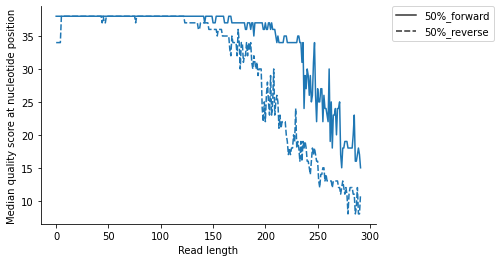

In [23]:
sepqscores, mergedscores, f_q_scores, r_q_scores = parse_quality_scores(runnumber, comm_id, composition)

In [60]:
scores = mergedscores[['length', '50%_forward', '50%_reverse']].copy()

In [30]:
#duplicate merged scores for prokaryotes
proks_mergedscores = mergedscores.copy()

In [31]:
#duplicate merged scores for eukaryotes
euks_mergedscores = mergedscores.copy()

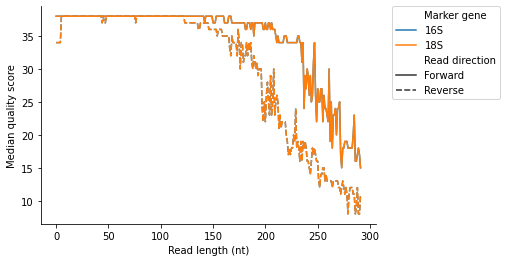

In [32]:
#once both euks and proks are duplicated, make line plot
toplot = pd.melt(euks_mergedscores, id_vars ='length', value_vars =['50%_forward', '50%_reverse'], var_name='Read direction')
toplot['Marker gene'] = '18S'
toplot_proks = pd.melt(proks_mergedscores, id_vars ='length', value_vars =['50%_forward', '50%_reverse'], var_name='Read direction')
toplot_proks['Marker gene'] = '16S'
merged= toplot_proks.append(toplot)
merged = merged.replace({'50%_forward': 'Forward', '50%_reverse':'Reverse'}, regex=True)
ax = sns.lineplot(data=merged, x="length", y="value", style="Read direction", hue='Marker gene', ci=None)
plt.xlabel("Read length (nt)")
plt.ylabel("Median quality score")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
fig = ax.get_figure()
fig.savefig(f'outputs/{comm_id}{composition}{runnumber}_readsqual_length_both_genes.png',
        bbox_inches = "tight", dpi=300)

Appended all taxonomies to stats


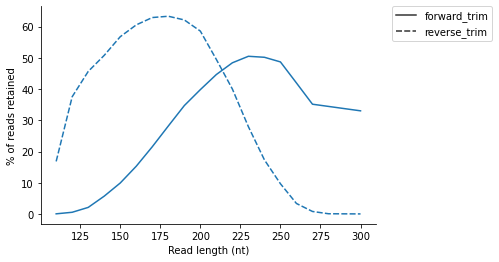

In [24]:
target_stats, forhm = load_df(comm, separated)

Bacaros Beta is already cloned.
in-silico-mocks/02-PROKs/Staggered/7fee7113-8e8a-459b-ae32-6d8381294d5c/data/taxonomy.tsv was moved.
Saved all taxonomies list as tax_comp.txt
BTD Already ran
The min value is 0.13953488372093026 and the max value is 0.13953488372093026


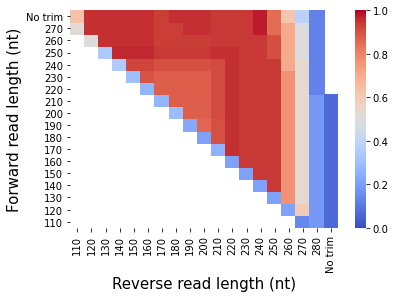

In [25]:
tohm, dest_dir, against_exp = make_tbd_hm(comm, composition, runnumber, level=7)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


The min value is 8.012354659995468e-05 and the max value is 8.012354659995468e-05


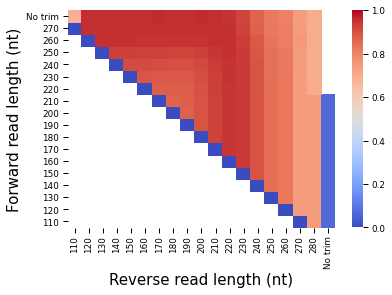

In [34]:
expected_silva_selected, testcopy, expobs_comp, tohm, fpfps, df = expected_df(comm, composition, separated)

In [27]:
make_fasta(comm, R, F, composition, runnumber)

Saved selected sequences as 02-PROKs/intermediate_files/all_seqs/RallFall46Staggered.fasta


In [28]:
tax_key = make_phylo_tree()

[INFO] 4528 duplicated records removed
     368 out.fa
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
    1 / 46
done.

Constructing a UPGMA tree (efffree=0) ... 
   40 / 46
done.

Progressive alignment 1/2... 
STEP    35 / 45 
Reallocating..done. *alloclen = 1760
STEP    45 / 45 
done.

Making a distance matrix from msa.. 
    0 / 46
done.

Constructing a UPGMA tree (efffree=1) ... 
   40 / 46
done.

Progressive alignment 2/2... 
STEP    37 / 45 
Reallocating..done. *alloclen = 1759
STEP    45 / 45 
done.

disttbfast (nuc) Version 7.475
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man'

In [41]:
dat1 = tax_key.copy()
dat1.rename({'key': 'ID'}, axis=1, inplace=True)
dat1['Phylum'] = dat1['Taxon'].str.split('; ').str[1]
dat1['Phylum'] = dat1['Phylum'].str.split('p__').str[1]
dat1 = dat1.drop_duplicates()

In [ ]:
tomerge = separated[['feature_id', 'Taxon', 'ratio']].copy()
dat1_t = dat1.merge(tomerge, on=['feature_id', 'Taxon'], how='left')
newzi = dat1_t.groupby('ID').mean()
newzi = dat1_t.groupby(['ID'], as_index=False).agg({'Taxon': 'first', 'ratio': 'mean', 'Phylum': 'first'})

In [94]:
dftax2 = dftax[['Taxon', 'Staggered_percent_expected', 'Clone_name']].copy()
newziz = newzi.merge(dftax2, on=['Taxon'], how='left')
newziz[composition+'_percent_expected'] = newziz[composition+'_percent_expected'].apply(pd.to_numeric)
newziz[composition+'_percent_expected'] = newziz[composition+'_percent_expected'].fillna(0)
newziz['Type'] = np.where(
    newziz[composition+'_percent_expected'] > 0, 'TP', 'FP')
newziz.drop_duplicates()

In [112]:
forsize = separated.copy()
forsize['ratio'] = forsize['ratio'].apply(pd.to_numeric)
forsize['ratio'] = forsize['ratio'].fillna(0)
forsize['Size'] = np.where(
    forsize['ratio'] > 0, 1, 0)
forsize = forsize.groupby(['Taxon']).sum()
forsize = forsize[['Taxon', 'table_id', 'Size']].copy()
forsize = forsize.groupby(['table_id','Taxon']).first()
forsize.reset_index()
forsize = forsize.groupby(['Taxon']).sum()
forsize['Size_perc'] = (forsize['Size'] / 199)*100 #if proks: 199, if euks
forsize.reset_index()
newziz = newziz.merge(forsize, on='Taxon', how='left')

In [147]:
dat1 = newziz[['ID', 'Phylum', 'Type', 'Size_perc']]
dat1.to_csv('dat1.csv', index=False)

In [138]:
dat2 = dat1_t[['ID', 'ratio']].copy()
dat2.rename(columns={'ratio': 'Abundance'}, inplace=True)
dat2.to_csv('dat2.csv', index=False)

<Figure size 360x360 with 0 Axes>

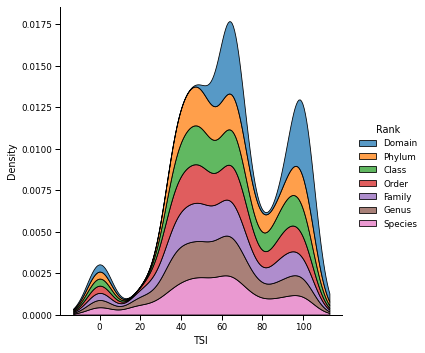

In [90]:
df_thresh, melted = thresholds()

In [33]:
fps = expobs_comp.loc[expobs_comp['Clone_name'] == 'False positive']

In [29]:
fpfps["forward_trim"].replace({0: 300}, inplace=True) #0 trim length translates to no trimming, so max read length
fpfps["reverse_trim"].replace({0: 300}, inplace=True)
fpfps["forward_trim"] = pd.to_numeric(fpfps["forward_trim"])
fpfps["reverse_trim"] = pd.to_numeric(fpfps["reverse_trim"])

In [61]:
#forward and reverse scores df for future use
fscores = scores[['50%_forward', 'length']].copy()
fscores.rename(columns={'length':'forward_trim'}, inplace=True)
rscores = scores[['50%_reverse', 'length']].copy()
rscores.rename(columns={'length':'reverse_trim'}, inplace=True)
mergeddf = fpfps.merge(fscores, how='left', on='forward_trim')
mergeddf = mergeddf.merge(rscores, how='left', on='reverse_trim')

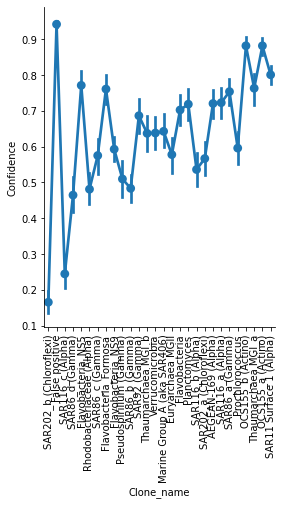

In [27]:
sns.catplot(data=fpfps, x="Clone_name", y="Confidence", kind="point")
plt.xticks(rotation=90)
plt.savefig(f'outputs/{comm_id}{composition}{runnumber}_clones_confidence.png',
        bbox_inches = "tight", dpi=300)

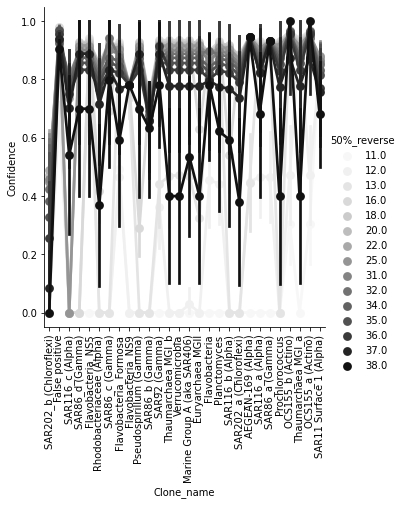

In [44]:
sns.catplot(data=mergeddf, x="Clone_name", y="Confidence", kind="point", hue='50%_reverse', palette='Greys')
plt.xticks(rotation=90)
plt.savefig(f'outputs/{comm_id}{composition}{runnumber}_clones_confidence_hue_rtrim_score.png',
        bbox_inches = "tight", dpi=300)

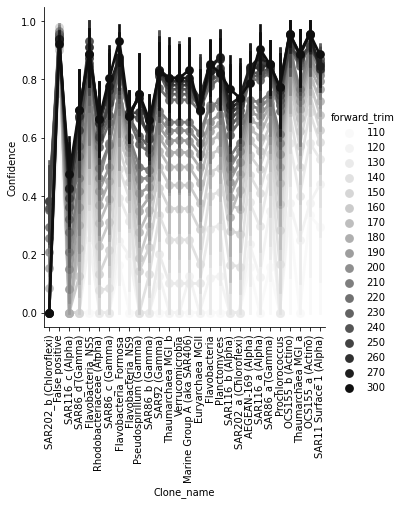

In [45]:
sns.catplot(data=fpfps, x="Clone_name", y="Confidence", kind="point", hue='forward_trim', palette='Greys')
plt.xticks(rotation=90)
plt.savefig(f'outputs/{comm_id}{composition}{runnumber}_clones_confidence_hue_ftrim.png',
        bbox_inches = "tight", dpi=300)

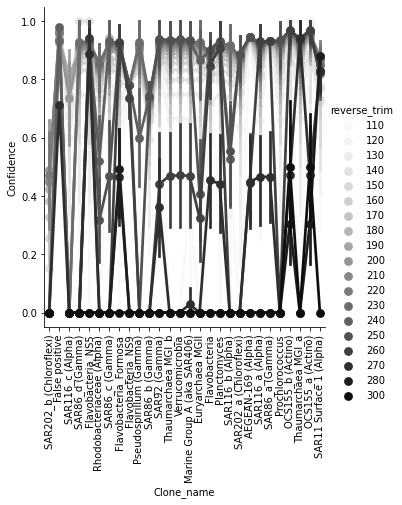

In [46]:
sns.catplot(data=fpfps, x="Clone_name", y="Confidence", kind="point", hue='reverse_trim', palette='Greys')
plt.xticks(rotation=90)
plt.savefig(f'outputs/{comm_id}{composition}{runnumber}_clones_confidence_hue_rtrim.png',
        bbox_inches = "tight", dpi=300)

In [35]:
make_clone_plots(expobs_comp)

/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)

<Figure size 432x288 with 0 Axes>

AEGEAN-169 (Alpha)
Ttest_1sampResult(statistic=-385.0787038218935, pvalue=0.0016532161737023885)
Euryarchaea MGII
Ttest_1sampResult(statistic=-58.208756924131265, pvalue=0.010935762712016283)
False positive
Ttest_1sampResult(statistic=-792.6743680864464, pvalue=0.0008031285736853659)
Flavobacteria
Ttest_1sampResult(statistic=-208.45295731211496, pvalue=0.003053997875654442)
Flavobacteria_Formosa
Ttest_1sampResult(statistic=-102.29651864971233, pvalue=0.00622308073990109)
Flavobacteria_NS5
Ttest_1sampResult(statistic=-119.86652738501795, pvalue=0.0053109489151527975)
Flavobacteria_NS9
Ttest_1sampResult(statistic=-112.15664902282373, pvalue=0.005676015724096629)
Marine Group A (aka SAR406)
Ttest_1sampResult(statistic=-16.87447296600846, pvalue=0.03768272325532668)
OCS155_a (Actino)
Ttest_1sampResult(statistic=14.64594210754713, pvalue=0.04339995572165176)
OCS155_b (Actino)
Ttest_1sampResult(statistic=14.64594210754713, pvalue=0.04339995572165176)
Planctomyces
Ttest_1sampResult(statistic=

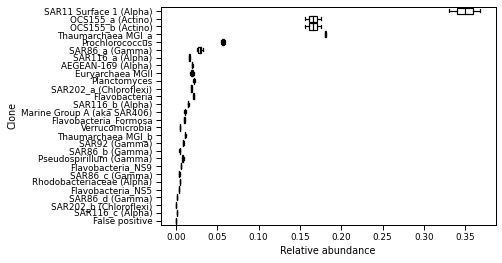

In [36]:
r_gr, newsi = ttst('F250R160', expected_silva_selected)

FP, recall and precision plots

In [68]:
expobs_comp_copy = expobs_comp[['table_id', 'ratio', 'Clone_name', 'sample-id', 'forward_trim', 'reverse_trim']].copy()
expobs_comp_copy['sums'] = expobs_comp_copy.groupby(['table_id', 'sample-id', 'Clone_name'])['ratio'].transform(lambda x: x.sum())
false_positives = expobs_comp_copy[expobs_comp_copy["Clone_name"] == 'False positive']
#falsies will be the observed ratio of FP across trim lengths
falsies = false_positives.drop(columns= ['ratio'])
falsies = falsies.drop_duplicates()
falsies = falsies[falsies.sums != 0]
falsies = falsies.groupby(['table_id', 'sample-id']).sum()
falsies_rep = falsies.groupby(['table_id']).mean()
#merging with all tables to include tables that didn't have FPs and fill with 0
all_tables = expobs_comp_copy[['table_id', 'forward_trim', 'reverse_trim']].copy()
all_tables = all_tables.drop_duplicates()
falsies_rep2 = falsies_rep.merge(all_tables, on=['forward_trim', 'reverse_trim'], how='outer')
falsies_rep2 = falsies_rep2.fillna(0)
#
falsies_rep2["forward_trim"].replace({0: 280}, inplace=True)
falsies_rep2["reverse_trim"].replace({0: 290}, inplace=True)

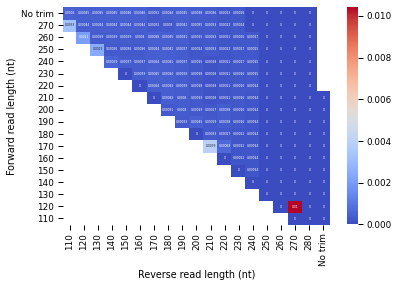

In [69]:
#false positive plots
tohm = falsies_rep2.pivot("forward_trim", "reverse_trim", "sums")
tohm.rename({280: 'No trim'}, axis=0, inplace=True)
tohm.rename({290: 'No trim'}, axis=1, inplace=True)
ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True, annot_kws={"fontsize":3})
ax.invert_yaxis()
ax.set(xlabel='Reverse read length (nt)', ylabel='Forward read length (nt)')

fig = ax.get_figure()
fig.savefig(f'outputs/{comm_id}{composition}{runnumber}falsies_annot.png', bbox_inches = "tight", dpi=300)

In [70]:
false_positives = expobs_comp[expobs_comp["Clone_name"] == 'False positive']
false_positives = false_positives.loc[~((false_positives['feature_frequency'] == 0))]
false_positives = false_positives[['sample-id', 'table_id', 'forward_trim', 'reverse_trim', 'Clone_name']].copy()
false_positives = false_positives.drop_duplicates()
fp_count = false_positives.groupby(['table_id', 'sample-id']).size().reset_index(name='fp_count')
fp_counts = fp_count.merge(all_tables, on='table_id', how='outer')
fp_counts.fillna(0)
#falsies = false_positives.drop(columns= ['Taxon'])
falsies = falsies.drop_duplicates()
fp_bool = falsies.groupby(['table_id', 'sample-id']).size().reset_index(name='fp_bool')
fp_bools = fp_bool.merge(all_tables, on='table_id', how='outer')
fp_bools.fillna(0)
expobs_comp_copy['n_clones_exp'] = expected_silva_selected.shape[0]
expobs_observed_only = expobs_comp_copy[expobs_comp_copy.sums != 0]
expobs_clonecount = expobs_observed_only.drop(columns=['ratio', 'sums'])
expobs_clonecount = expobs_clonecount.drop_duplicates()
obs_count = expobs_clonecount.groupby(['table_id', 'sample-id']).size().reset_index(name='counts')
expobs_clonecount = pd.merge(fp_bool, expobs_clonecount, on=['table_id', 'sample-id'], how='outer')
expobs_clonecount = pd.merge(obs_count, expobs_clonecount, on=['table_id', 'sample-id'], how='outer')
expobs_clonecount = pd.merge(fp_count, expobs_clonecount, on=['table_id', 'sample-id'], how='outer')
expobs_clonecount = expobs_clonecount.fillna(0)
expobs_clonecount['precision'] = ((expobs_clonecount['counts']-expobs_clonecount['fp_bool'])
                                  /((expobs_clonecount['counts']-expobs_clonecount['fp_bool'])+expobs_clonecount['fp_count']))
expobs_clonecount['recall'] = ((expobs_clonecount['counts']-expobs_clonecount['fp_bool'])
                               /((expobs_clonecount['counts']-expobs_clonecount['fp_bool'])+ (expobs_clonecount['n_clones_exp']-(expobs_clonecount['counts']-expobs_clonecount['fp_bool']))))
expobs_clonecount = expobs_clonecount.drop(columns='Clone_name')
expobs_clonecount = expobs_clonecount.drop_duplicates()

In [71]:
recall_rep = expobs_clonecount.groupby(['table_id']).mean()
recall_rep.sort_values('recall')

,fp_count,counts,fp_bool,forward_trim,reverse_trim,n_clones_exp,precision,recall
table_id,,,,,,,,
F270R280,0.0,1.5,0.0,270.0,280.0,27.0,1.000000,0.055556
F220R280,0.0,1.5,0.0,220.0,280.0,27.0,1.000000,0.055556
F260R280,0.0,1.5,0.0,260.0,280.0,27.0,1.000000,0.055556
F0R280,0.0,1.5,0.0,0.0,280.0,27.0,1.000000,0.055556
F250R280,0.0,1.5,0.0,250.0,280.0,27.0,1.000000,0.055556
...,...,...,...,...,...,...,...,...
F230R180,1.0,28.0,1.0,230.0,180.0,27.0,0.964286,1.000000
F230R170,1.0,28.0,1.0,230.0,170.0,27.0,0.964286,1.000000
F230R160,1.0,28.0,1.0,230.0,160.0,27.0,0.964286,1.000000


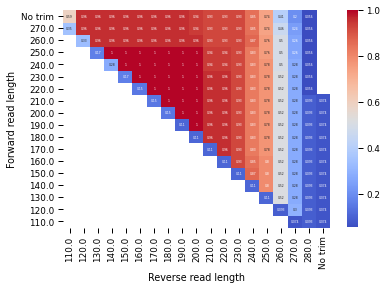

In [72]:
#recall plot
#recall_rep = expobs_clonecount[expobs_clonecount['sample-id'] == 'R46-18E-1']
recall_rep = expobs_clonecount.groupby(['table_id']).mean()
recall_rep["forward_trim"].replace({0: 280}, inplace=True)
recall_rep["reverse_trim"].replace({0: 290}, inplace=True)
tohm = recall_rep.pivot("forward_trim", "reverse_trim", "recall")
#tohm = tohm.fillna(0)
tohm.rename({280: 'No trim'}, axis=0, inplace=True)
tohm.rename({290: 'No trim'}, axis=1, inplace=True)

ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True, annot_kws={"fontsize":3})
ax.invert_yaxis()
ax.set(xlabel='Reverse read length', ylabel='Forward read length')

fig = ax.get_figure()
fig.savefig(f'outputs/{comm_id}{composition}{runnumber}recall_repavg_annot.png', bbox_inches = "tight", dpi=300)

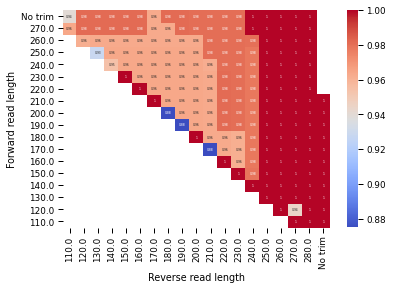

In [73]:
#recall_rep = expobs_clonecount[expobs_clonecount['sample-id'] == 'R46-18E-1']
recall_rep = expobs_clonecount.groupby(['table_id']).mean()
recall_rep["forward_trim"].replace({0: 280}, inplace=True)
recall_rep["reverse_trim"].replace({0: 290}, inplace=True)
tohm = recall_rep.pivot("forward_trim", "reverse_trim", "precision")
#tohm = tohm.fillna(0)
tohm.rename({280: 'No trim'}, axis=0, inplace=True)
tohm.rename({290: 'No trim'}, axis=1, inplace=True)

ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True, annot_kws={"fontsize":3})
ax.invert_yaxis()
ax.set(xlabel='Reverse read length', ylabel='Forward read length')

fig = ax.get_figure()
fig.savefig(f'outputs/{comm_id}{composition}{runnumber}precision_repavg.png', bbox_inches = "tight", dpi=300)

In [74]:
recall_rep['forward_trim'] = recall_rep['forward_trim'].astype('int64')
recall_rep['reverse_trim'] = recall_rep['reverse_trim'].astype('int64')
recall_reps = recall_rep.merge(fscores, how='left', on='forward_trim')
recall_reps = recall_reps.merge(rscores, how='left', on='reverse_trim')

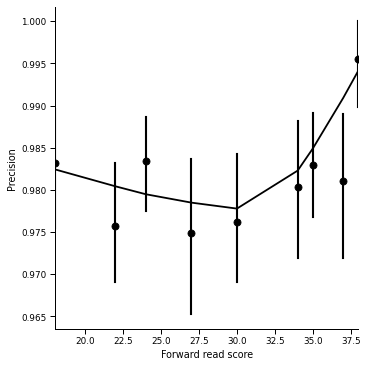

In [75]:
ax=sns.lmplot(x='50%_forward', y='precision', data=recall_reps, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Forward read score", y_var="Precision")
#ax.set(ylim=(0, 1))

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_prec_fread_wscore.png',
                bbox_inches = "tight")

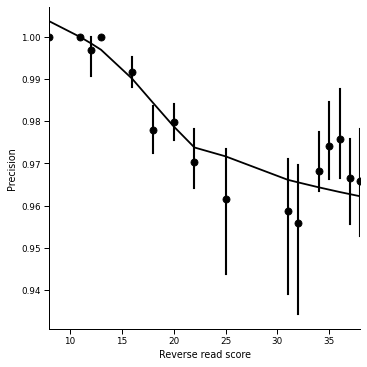

In [76]:
ax=sns.lmplot(x='50%_reverse', y='precision', data=recall_reps, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Reverse read score", y_var="Precision")
#ax.set(ylim=(0, 1))

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_prec_rread_wscore.png',
                bbox_inches = "tight")

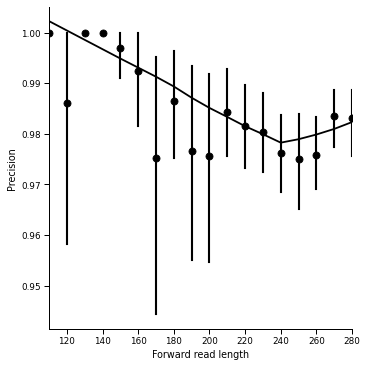

In [77]:
ax=sns.lmplot(x='forward_trim', y='precision', data=recall_rep, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Forward read length", y_var="Precision")
#ax.set(ylim=(0, 1))

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_precision_fread_lmplot_ylim.png',
                bbox_inches = "tight")

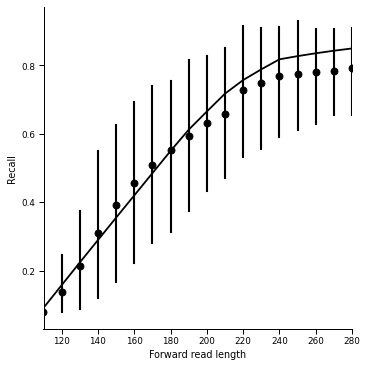

In [78]:
ax=sns.lmplot(x='forward_trim', y='recall', data=recall_rep, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Forward read length", y_var="Recall")

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_recall_fread_lmplot.png',
                bbox_inches = "tight")

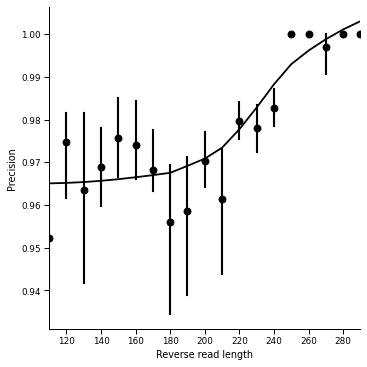

In [79]:
ax=sns.lmplot(x='reverse_trim', y='precision', data=recall_rep, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Reverse read length", y_var="Precision")

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_precision_rread_lmplot.png',
                bbox_inches = "tight")

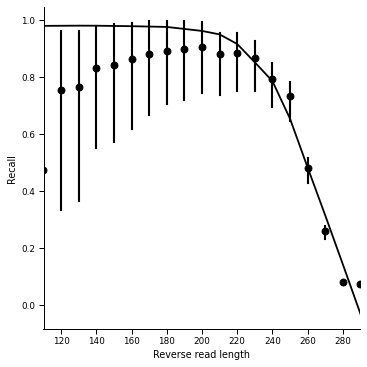

In [80]:
ax=sns.lmplot(x='reverse_trim', y='recall', data=recall_rep, x_estimator=np.mean,
             scatter_kws={"color": "black"}, line_kws={"color": "black"}, lowess=True)

ax.set_axis_labels(x_var="Reverse read length", y_var="Recall")

    
ax.savefig(f'outputs/{comm_id}{composition}{runnumber}_recall_rread_lmplot.png',
                bbox_inches = "tight")